In [ ]:
#Cài đặt môi trường và thư viện

In [ ]:
!pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=59dd70f7324ebe44b661128028ce7f2750acbee1fa2f559f110ddc746c634252
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import os
import pandas as pd

In [ ]:
spark = SparkSession.builder\
        .master('local[*]')\
        .appName('Connection-Test')\
        .config('spark.driver.extraClassPath', '/content/drive/MyDrive/DE - test/mssql-jdbc-12.2.0.jre8.jar')\
        .config('spark.executor.extraClassPath', '/content/drive/MyDrive/DE - test/mssql-jdbc-12.2.0.jre8.jar')\
        .getOrCreate()

In [ ]:
def ETL_1_day(path, name):
    # Đọc file 1 để sau đó union các file khác vào
    file_list = os.listdir(f'{path}/{name}')
    parquet_file = [file_name for file_name in file_list if file_name.endswith(".parquet")]
    df = spark.read.parquet(f'{path}/{name}/{parquet_file[0]}')
    df = df.withColumn('Month', lit(name[4:6]))
    return df


In [ ]:
# Function xử lý dữ liệu log search
def ETL_all_day(folder_path):
    folder_list = os.listdir(folder_path)
    # Đọc data 1 ngày
    df = ETL_1_day(path = folder_path, name = folder_list[0])
    # Đọc qua tất cả data
    for file in folder_list[1:]:
        df1 = ETL_1_day(path = folder_path, name = file)
        df = df.union(df1)
        df = df.cache()
    # Lọc action là search, user_id và keyword not Null
    df = df.filter((col('action') == 'search') & (col('user_id').isNotNull()) & (col('keyword').isNotNull()))
    return df

In [ ]:
def most_search(df, month):
    # Tìm ra Most Search T6
    df = df.filter(col('Month') == month)
    df = df.select('user_id', 'keyword', 'Month')
    df = df.groupBy('user_id', 'keyword', 'Month').count()
    df = df.withColumnRenamed('count', 'Total_search').orderBy('Total_search', ascending= False)
    window = Window.partitionBy('user_id').orderBy(col('Total_search').desc())
    df = df.withColumn('Rank', row_number().over(window))
    df = df.filter(col('Rank') == 1)
    df = df.withColumnRenamed('keyword','Most_Search')
    df = df.select('user_id','Most_Search', 'Month')
    return df

### Xử lý Data thang 6, 7

In [ ]:
folder_path = '/content/drive/MyDrive/DE - test/log_search'

In [ ]:
df = ETL_all_day(folder_path)

In [ ]:
df.show(10)

+--------------------+--------------------+--------+--------------------+--------+---------+--------------------+-----------+------+--------------------+-----+
|             eventID|            datetime| user_id|             keyword|category|proxy_isp|            platform|networkType|action|        userPlansMap|Month|
+--------------------+--------------------+--------+--------------------+--------+---------+--------------------+-----------+------+--------------------+-----+
|22c35287-9fe1-487...|2022-06-01 18:59:...|44887906|            trữ tình|   enter|     vnpt|   fplay-ottbox-2019|   ethernet|search|                  []|   06|
|f9af5a95-1f72-486...|2022-06-01 18:59:...| 2719170|              bolero|   enter|  viettel|   fplay-ottbox-2019|   ethernet|search|[Kênh Gia Đình:pr...|   06|
|d51e6e6c-2765-4a8...|2022-06-01 19:00:...| 8830996|cậu mang à sĩ hanako|   enter|     vnpt|smarttv-sony-android|       wifi|search|[Kênh Gia Đình:pr...|   06|
|3948ea18-8c86-451...|2022-06-01 19:00:.

In [ ]:
df_t6 = most_search(df, month = '06')
df_t7 = most_search(df, month = '07')

#Map cột Most_Search với category để xác định thể loại user tìm kiếm nhiều nhất

In [ ]:
key_dict_pd = pd.read_excel('/content/drive/MyDrive/DE - test/key_dict_1000.xlsx')
key_dict = spark.createDataFrame(key_dict_pd)

In [ ]:
df_t6 = df_t6.join(key_dict, 'Most_Search', 'inner').select('user_id', 'Most_Search', 'Category')
df_t6 = df_t6.withColumnRenamed('Most_Search', 'Most_Search_T6')\
              .withColumnRenamed('Category', 'Category_T6')

In [ ]:
df_t7 = df_t7.join(key_dict, 'Most_Search', 'inner').select('user_id', 'Most_Search', 'Category')
df_t7 = df_t7.withColumnRenamed('Most_Search', 'Most_Search_T7')\
              .withColumnRenamed('Category', 'Category_T7')

#Data user Most Search - Category user search trong tháng 6, 7

In [ ]:
df_t6.show(10)

+--------+--------------------+-----------+
| user_id|      Most_Search_T6|Category_T6|
+--------+--------------------+-----------+
|49138855|                viee|      Drama|
|41099897|         Be Mbitious|     Action|
|42040511|         Be Mbitious|     Action|
|95746783|  all of us are dead|      Honor|
|42994058|    công chúa ohrora|    Cartoon|
| 1148500| em là thành trì ...|    Romance|
|99339051|               pucca|    Cartoon|
|45777581|                vtv6|     Family|
|96556581|                vtv6|     Family|
|97836223|                vtv6|     Family|
+--------+--------------------+-----------+
only showing top 10 rows



In [ ]:
df_t7.show(10)

+--------+--------------------+-----------+
| user_id|      Most_Search_T7|Category_T7|
+--------+--------------------+-----------+
|06699257| bong đá u19 thái...|      Sport|
|49540856|              orient|     Action|
|94783979|              orient|     Action|
|42563626|   #cỗ máy thời gian|    Cartoon|
|06541734|  100 ngay minecraft|   Dicovery|
|41735834|          13 minutes|      Sport|
|  105435|                2IN4|      Sport|
|95338065|             30 chưa|      Drama|
|95338065|             30 chưa|   Dicovery|
|42676220|             365 dni|     Family|
+--------+--------------------+-----------+
only showing top 10 rows



In [ ]:
df_all = df_t6.join(df_t7, 'user_id', 'inner')

In [ ]:
condition = col('Category_T6') == col('Category_T7')

In [ ]:
df_all = df_all.withColumn('Category_change', when(condition, 'NoChange').otherwise(concat(df_all['Category_T6'], lit(' - '), df_all['Category_T7'])))


In [ ]:
df_all.show(10, truncate= False)

+--------+---------------+-----------+-----------------------+-----------+---------------+
|user_id |Most_Search_T6 |Category_T6|Most_Search_T7         |Category_T7|Category_change|
+--------+---------------+-----------+-----------------------+-----------+---------------+
|105435  |lucy           |Cartoon    |2IN4                   |Sport      |Cartoon - Sport|
|105435  |lucy           |Cartoon    |2IN4                   |Sport      |Cartoon - Sport|
|49954667|anime          |Cartoon    |lop hoc uu tu seasons 2|Drama      |Cartoon - Drama|
|49954667|anime          |Cartoon    |lop hoc uu tu seasons 2|Drama      |Cartoon - Drama|
|41838039|hạc lệ hoa đình|Family     |khách sạn ma quái      |Honor      |Family - Honor |
|41838039|hạc lệ hoa đình|Family     |khách sạn ma quái      |Honor      |Family - Honor |
|49970336|một con vịt    |Cartoon    |một con vịt            |Cartoon    |NoChange       |
|49970336|một con vịt    |Cartoon    |một con vịt            |Cartoon    |NoChange       |

In [ ]:
df_all.count()

586

#Bắn data vào Azure SQL Database

In [30]:
jdbcHostname = 'phamvy1.database.windows.net'
jdbcDatabase = 'TestDE'
jdbcUsername = 'username'
jdbcPassword = 'pass'
jdbcPort = 1433  # Default port for Azure SQL Database
jdbcUrl = f"jdbc:sqlserver://{jdbcHostname}:{jdbcPort};database={jdbcDatabase};user={jdbcUsername};password={jdbcPassword};encrypt=true;trustServerCertificate=false;hostNameInCertificate=*.database.windows.net;loginTimeout=30;"


In [ ]:
!curl ipecho.net/plain

35.199.34.144

In [29]:
df_t6.write.jdbc(jdbcUrl,
                   mode ="append",
                   table= 'Most_Search_T6'
                   )


In [31]:
df_t7.write.jdbc(jdbcUrl,
                   mode ="append",
                   table= 'Most_Search_T7'
                   )

In [32]:
df_all.write.jdbc(jdbcUrl,
                   mode ="append",
                   table= 'Most_Search_T6_and_T7'
                   )

#Phân tích data

In [33]:
import matplotlib.pyplot as plt

# Phân tích Category xem của user trong tháng 6

In [34]:
data_t6 = df_t6.toPandas()

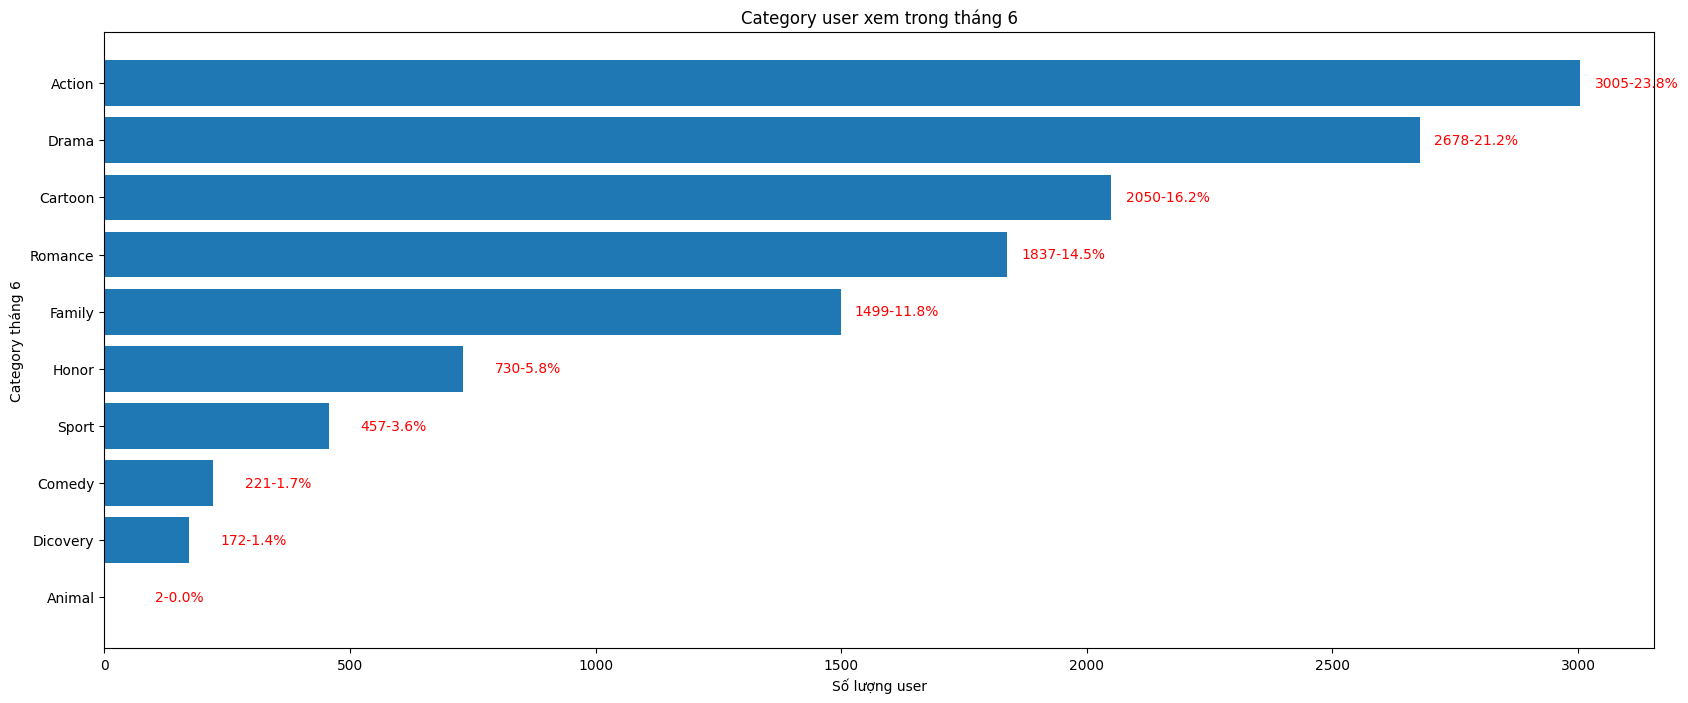

In [35]:
plt.figure(figsize=(20,8))
y = data_t6['Category_T6'].value_counts().index
x = data_t6['Category_T6'].value_counts().values
padding = 200
for i in range(len(x)):
    plt.text(x[i] + padding, i, str(x[i]) + '-' + (f'{(x[i] / (x.sum())) * 100:.1f}%'), ha='right', va='center', color = 'red')
plt.barh(y,x)
plt.xlabel('Số lượng user')
plt.ylabel('Category tháng 6')
plt.title('Category user xem trong tháng 6')
plt.gca().invert_yaxis()


# Phân tích Category xem của user trong tháng 7

In [36]:
data_t7 = df_t7.toPandas()

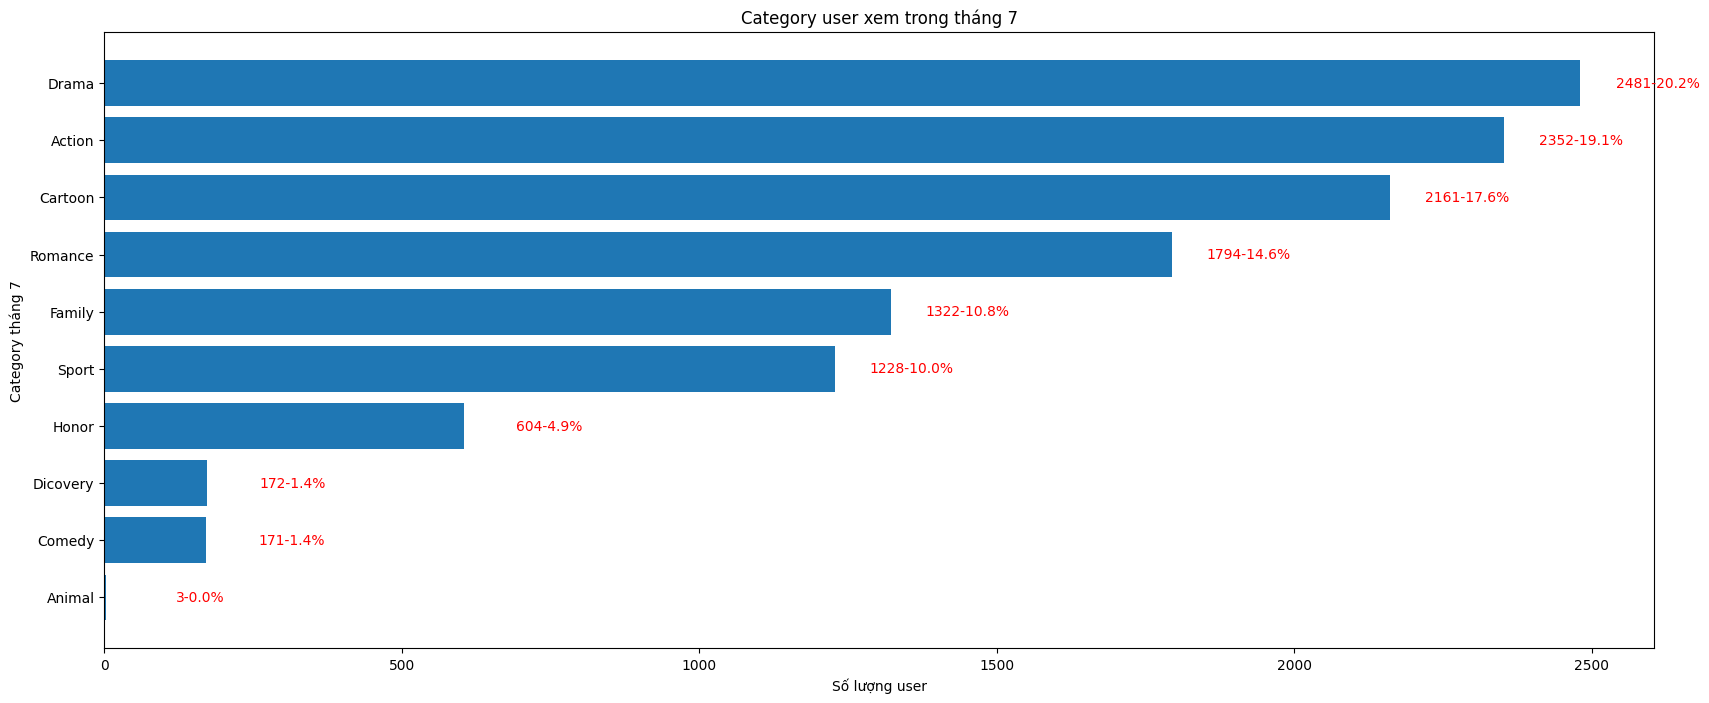

In [37]:
plt.figure(figsize=(20,8))
y = data_t7['Category_T7'].value_counts().index
x = data_t7['Category_T7'].value_counts().values
padding = 200
for i in range(len(x)):
    plt.text(x[i] + padding, i, str(x[i]) + '-' + (f'{(x[i] / (x.sum())) * 100:.1f}%'), ha='right', va='center', color = 'red')
plt.barh(y,x)
plt.xlabel('Số lượng user')
plt.ylabel('Category tháng 7')
plt.title('Category user xem trong tháng 7')
plt.gca().invert_yaxis()


#Sự thay đổi Category xem của user trong tháng 6 tới tháng 7

In [38]:
data_all = df_all.toPandas()

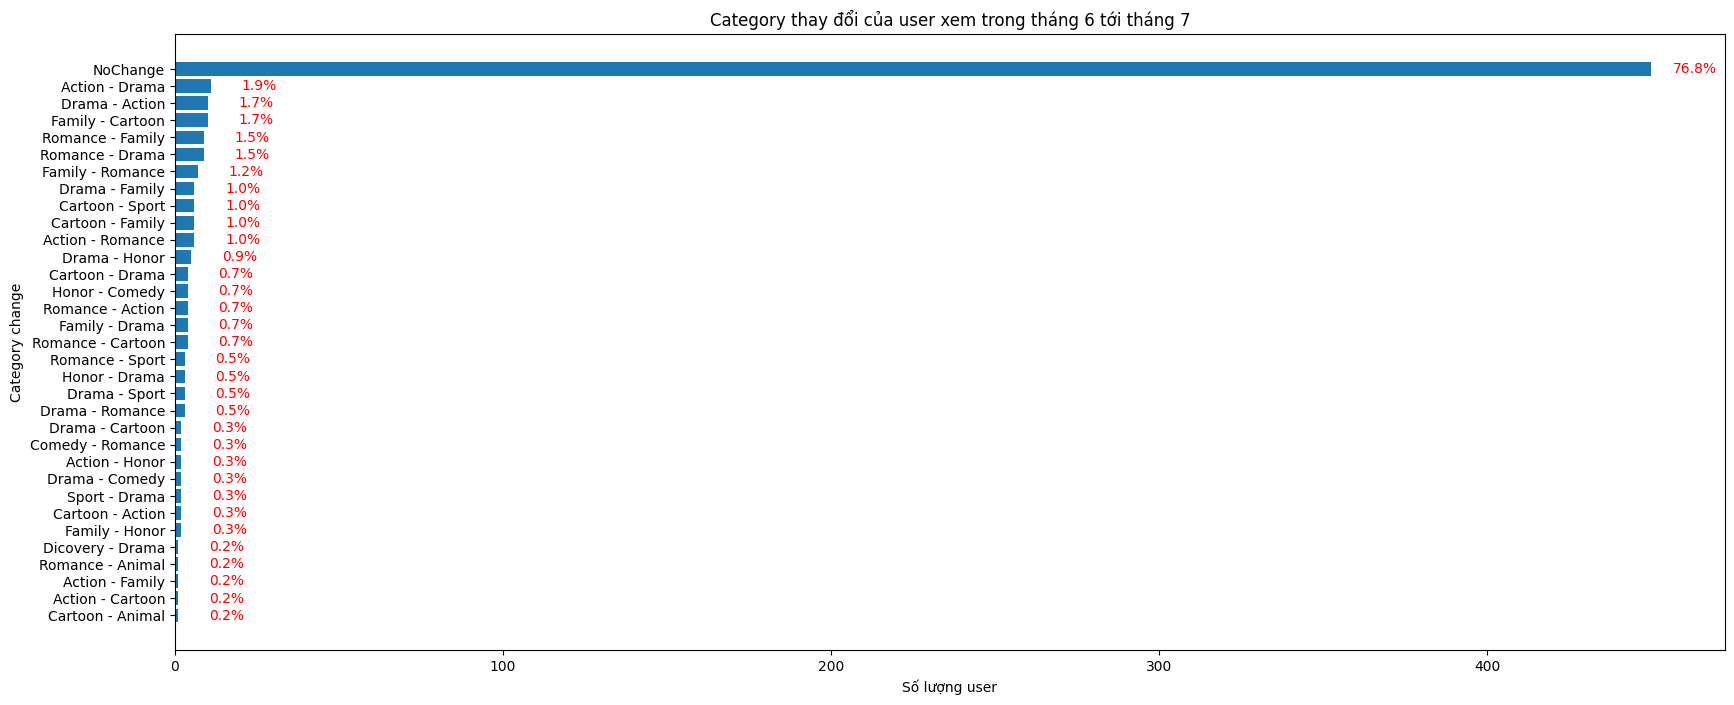

In [39]:
plt.figure(figsize=(20,8))
y = data_all['Category_change'].value_counts().index
x = data_all['Category_change'].value_counts().values
padding = 20
for i in range(len(x)):
    plt.text(x[i] + padding, i, f'{(x[i] / (x.sum())) * 100:.1f}%', ha='right', va='center', color = 'red')
plt.barh(y,x)
plt.xlabel('Số lượng user')
plt.ylabel('Category change')
plt.title('Category thay đổi của user xem trong tháng 6 tới tháng 7')
plt.gca().invert_yaxis()